# 기본 설정

In [1]:
import pandas as pd
import zipfile
import shutil
import os
from PIL import Image
import numpy as np
from keras.models import load_model

In [2]:
zip_file = zipfile.ZipFile('/content/drive/MyDrive/Pokemon_1stGen.zip', 'r')
extract_dir = 'train'
zip_file.extractall(extract_dir)

In [3]:
# 사전 훈련된 모델 load, 여기선 간단히 VGG16 사용
model = load_model('/content/drive/MyDrive/test.h5')
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 8192)              0         
                                                                 
 dense_17 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 149)               38293     
                                                                 
Total params: 16,850,389
Trainable params: 2,135,701
Non-trainable params: 14,714,688
_________________________________________________________________


In [4]:
# 실험용 파이리 사진 10장
shutil.copytree("/content/drive/MyDrive/charmander_test", "charmander_test")

'charmander_test'

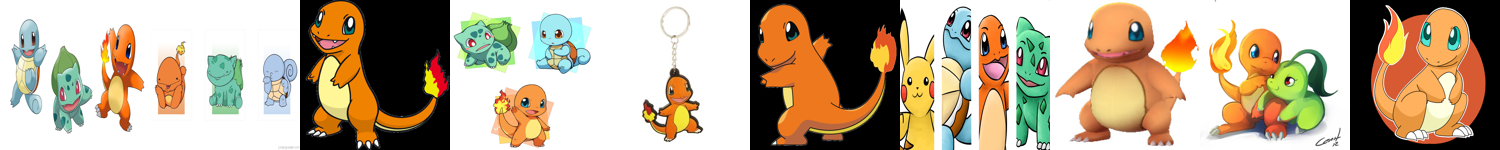

In [8]:
# 저장된 원본 이미지 10장 확인
img_total = Image.new("RGB", (1500, 150), "white")

i = 0
for file in os.listdir('/content/charmander_test'):
  img_path = os.path.join('/content/charmander_test', file)
  img = Image.open(img_path).convert('RGB')

  img = img.resize((150, 150))
  img_total.paste(img, (150*i, 0))
  i+=1

img_total.show()

# 알고리즘 구현

In [13]:
def load_image_from_directory(path):
  files = []
  for file in os.listdir(path):
    if file.endswith('ipynb_checkpoints'):
      continue
    files.append(os.path.join(path, file))
  
  return files

def model_predict(model, img, class_labels):

  img = img.resize((150, 150))
  img = np.asarray(img)  
  img = img / 255.0 

  img = np.expand_dims(img, axis=0)
  pred = model.predict(img, verbose=0)
  return class_labels[np.argmax(pred)], np.max(pred)

def calc_sliding(img, grid_size, kernel_size, grid_width, grid_height):
  n_iter = grid_size - kernel_size + 1
  img_crops = []

  for i in range(n_iter):
    for j in range(n_iter):
      img_crop = img.crop((grid_width * j, grid_height * i, 
                           kernel_size * grid_width + j * grid_width, kernel_size * grid_height + i * grid_height))
      img_crops.append(img_crop)

  for i in range(n_iter):
    img_crop = img.crop((grid_width * i, 0,
                         kernel_size * grid_width + i * grid_width, grid_size * grid_height))
    img_crops.append(img_crop)

  for i in range(n_iter):
    img_crop = img.crop((0, i  * grid_height,
                         grid_size * grid_width, kernel_size * grid_height + i * grid_height))
    img_crops.append(img_crop)
    
  return img_crops


def Self_Extraction(model, path, class_name, grid_size=9, kernel_size=5, remove_original=True, verbose=True):
  '''
  Parameter
  model: 사전 훈련된 CNN 모델
  path: 한 종류의 포켓몬 데이터가 저장된 경로
  class_name: 하나의 포켓몬 이름(레이블)
  grid_size: 전체 이미지를 구분하는 격자의 크기. grid_size=5이면 전체 이미지를 5x5로 분할. 홀수만 입력
  kernel_size: 슬라이딩 연산을 적용할 kernel의 크기. kernel_size=3이면 3x3 크기의 커널을 슬라이딩 하여 계산. 홀수만 입력

  Output
  Self Extraction 적용을 마친 이미지 리스트
  '''

  # 훈련 데이터셋의 전체 포켓몬 레이블
  class_labels = sorted(os.listdir('train'))

  # 하나의 포켓몬에 대한 파일 저장
  files = load_image_from_directory(path)

  if kernel_size % 2 != 1 or grid_size %2 != 1:
    print('kernel_size, grid_size는 홀수만 입력')
    return
  
  i=0

  for file in files:
    # 전체 이미지에 대한 예측 수행
    img = Image.open(file).convert('RGB')
    try:
      entire_class, entire_score = model_predict(model, img, class_labels)
    except TypeError:
      continue
    
    i += 1
    if verbose:
      print('%d번째 이미지' %i)
      print('전체 이미지에 대한 예측: ', entire_class, entire_score)

    sub_classes = []
    sub_scores = []

    # 그리드 한 칸의 너비, 높이 계산 
    grid_w = img.size[0] // grid_size
    grid_h = img.size[1] // grid_size
    
    
    # 전체 이미지 부분 공간 모음 img_crops 계산
    img_crops = calc_sliding(img, grid_size, kernel_size, grid_w, grid_h)

    # 원본 이미지를 정사각형 형태로 resize한 img_square에도 sliding 연산 수행
    if img.size[0] > img.size[1]:
      img_square = img.resize((img.size[0], img.size[0]))
      img_crops_square = calc_sliding(img_square, grid_size, kernel_size, grid_w, grid_w)
    else:
      img_square = img.resize((img.size[1], img.size[1]))
      img_crops_square = calc_sliding(img_square, grid_size, kernel_size, grid_h, grid_h)

    img_crops.extend(img_crops_square)

    # 전체 crop에 대한 예측 수행
    for crop in img_crops:
      sub_class, sub_score = model_predict(model, crop, class_labels)
      sub_classes.append(sub_class)
      sub_scores.append(sub_score)

    # 올바른 레이블로 예측된 crop 중 가장 높은 점수와 그때의 인덱스 확인
    sub_classes = pd.Series(sub_classes)
    sub_scores = pd.Series(sub_scores)

    try:
      max_sub_score = np.max(sub_scores[sub_classes == class_name])
      max_sub_score_index = sub_scores[sub_scores==max_sub_score].index[0]
    except IndexError:
      if verbose:
        print('올바른 부분 이미지 부재')
        print()
      continue
      
    if verbose:
      print('부분 이미지에 대한 최고 예측: ', class_name, max_sub_score)

    # 전체 이미지에 대해 올바른 예측을 한 경우
    if entire_class == class_name:
      # crop의 점수가 전체 이미지의 점수보다 높다면
      if max_sub_score > entire_score:
        # 새로운 이미지 저장
        new_img = img_crops[max_sub_score_index]
        new_img.save(file[:-4] + '_new' + '.jpg')
        if verbose:
          print('새 이미지 생성')
          print()
        # 기존 이미지 제거
        if remove_original:
            os.remove(file)
      else:
        if verbose:
          print()

    # 전체 이미지에 대해 올바른 예측을 못한 경우
    elif entire_class != class_name:
      new_img = img_crops[max_sub_score_index]
      new_img.save(file[:-4] + '_new' + '.jpg')
      if verbose:
        print('새 이미지 생성')
        print()
      # 기존 이미지 제거
      if remove_original:
          os.remove(file)
  
  print('--- Self Extraction Done ---')

In [10]:
Self_Extraction(model, '/content/charmander_test', 'Charmander')

1번째 이미지
전체 이미지에 대한 예측:  Squirtle 0.59565234
부분 이미지에 대한 최고 예측:  Charmander 0.9839934
새 이미지 생성

2번째 이미지
전체 이미지에 대한 예측:  Bulbasaur 0.5880397
부분 이미지에 대한 최고 예측:  Charmander 0.526017
새 이미지 생성

3번째 이미지
전체 이미지에 대한 예측:  Charmander 0.99999785
부분 이미지에 대한 최고 예측:  Charmander 0.9999988
새 이미지 생성

4번째 이미지
전체 이미지에 대한 예측:  Charmander 0.62162745
부분 이미지에 대한 최고 예측:  Charmander 0.9946866
새 이미지 생성

5번째 이미지
전체 이미지에 대한 예측:  Charmander 0.9993906
부분 이미지에 대한 최고 예측:  Charmander 0.9991078

6번째 이미지
전체 이미지에 대한 예측:  Charmander 0.9999951
부분 이미지에 대한 최고 예측:  Charmander 0.9999801

7번째 이미지
전체 이미지에 대한 예측:  Squirtle 0.8798504
부분 이미지에 대한 최고 예측:  Charmander 0.997015
새 이미지 생성

8번째 이미지
전체 이미지에 대한 예측:  Charmander 0.9999765
부분 이미지에 대한 최고 예측:  Charmander 0.99994946

9번째 이미지
전체 이미지에 대한 예측:  Charmander 0.9993851
부분 이미지에 대한 최고 예측:  Charmander 0.9999527
새 이미지 생성

10번째 이미지
전체 이미지에 대한 예측:  Charmander 0.9999237
부분 이미지에 대한 최고 예측:  Charmander 0.9963111

--- Self Extraction Done ---


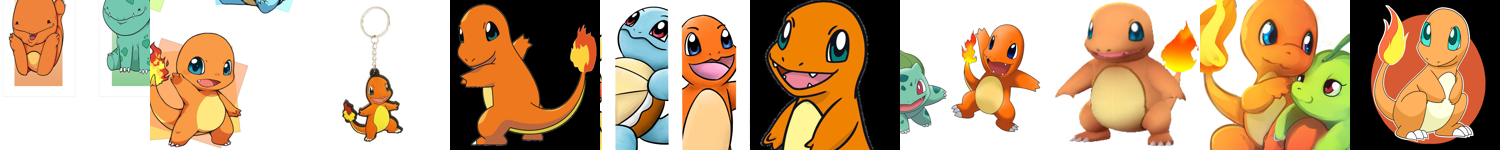

In [11]:
# 다시 10개의 이미지 확인
img_total = Image.new("RGB", (1500, 150), "white")

i = 0
for file in os.listdir('/content/charmander_test'):
  img_path = os.path.join('/content/charmander_test', file)
  img = Image.open(img_path).convert('RGB')

  img = img.resize((150, 150))
  img_total.paste(img, (150*i, 0))
  i+=1

img_total.show()

In [14]:
# 반복적으로 실행하며 수렴하는지 확인
Self_Extraction(model, '/content/charmander_test', 'Charmander')

1번째 이미지
전체 이미지에 대한 예측:  Charmander 0.49527287
2번째 이미지
전체 이미지에 대한 예측:  Charmander 0.99489474
부분 이미지에 대한 최고 예측:  Charmander 0.99985564
새 이미지 생성

3번째 이미지
전체 이미지에 대한 예측:  Charmander 0.9993906
부분 이미지에 대한 최고 예측:  Charmander 0.9991078

4번째 이미지
전체 이미지에 대한 예측:  Charmander 0.9999951
부분 이미지에 대한 최고 예측:  Charmander 0.9999801

5번째 이미지
전체 이미지에 대한 예측:  Charmander 0.99683607
부분 이미지에 대한 최고 예측:  Charmander 0.999959
새 이미지 생성

6번째 이미지
전체 이미지에 대한 예측:  Charmander 0.9999988
부분 이미지에 대한 최고 예측:  Charmander 0.99998367

7번째 이미지
전체 이미지에 대한 예측:  Charmander 0.9826974
부분 이미지에 대한 최고 예측:  Charmander 0.9999976
새 이미지 생성

8번째 이미지
전체 이미지에 대한 예측:  Charmander 0.9999765
부분 이미지에 대한 최고 예측:  Charmander 0.99994946

9번째 이미지
전체 이미지에 대한 예측:  Charmander 0.99994755
부분 이미지에 대한 최고 예측:  Charmander 0.9999944
새 이미지 생성

10번째 이미지
전체 이미지에 대한 예측:  Charmander 0.9999237
부분 이미지에 대한 최고 예측:  Charmander 0.9963111

--- Self Extraction Done ---


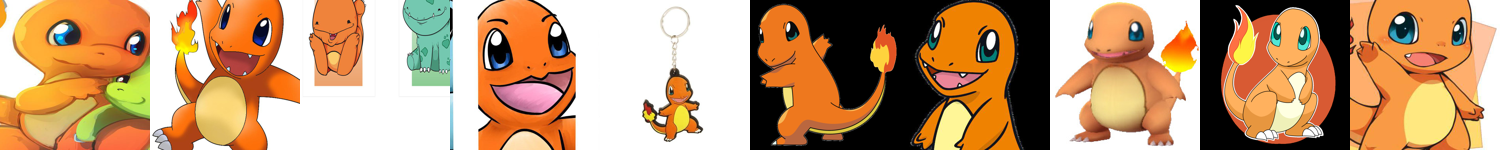

In [15]:
# 다시 10개의 이미지 확인
img_total = Image.new("RGB", (1500, 150), "white")

i = 0
for file in os.listdir('/content/charmander_test'):
  img_path = os.path.join('/content/charmander_test', file)
  img = Image.open(img_path).convert('RGB')

  img = img.resize((150, 150))
  img_total.paste(img, (150*i, 0))
  i+=1

img_total.show()

3번째 이미지를 제외하고, 모두 파이리의 모습으로 수렴한 것을 확인할 수 있다.